In [206]:
# Install libraries
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
import yaml
from pandas.core.common import SettingWithCopyWarning
import matplotlib.pyplot as plt
import seaborn as sns

In [207]:
# Load config file with constants 
def load_config():
    try:
        with open('config_file.yaml') as f:
            global constants
            constants = yaml.safe_load(f)
    except OSError as e:
        raise e
    except Exception as e:
        raise e

load_config()

In [5]:
# Import  data
# File name is specified in config file. Engine pyxlsb allow to read .xlsb files
data_input = pd.read_excel(constants['INPUT_FILE_NAME'], sheet_name='data', engine='pyxlsb')
real_input = pd.read_excel(constants['INPUT_FILE_NAME'], sheet_name='Real', engine='pyxlsb')
bandwidth_input = pd.read_excel(constants['INPUT_FILE_NAME'], sheet_name='PS', engine='pyxlsb')
match_input = pd.read_excel(constants['INPUT_FILE_NAME'], sheet_name='match', engine='pyxlsb')

In [208]:
# Copy datasets to implement further changes
data = data_input.copy()
real = real_input.copy()
bandwidth = bandwidth_input.copy()
match = match_input.copy()

In [209]:
# Create a dictionary with names of columns that we are going to use
names = {"Тариф" : "cost",
        "Плечо" : "distance",
        "Дата" : "date",
        "НБ" : "origin",
        "ОУ" : "point",
        "НП" : "brand",
        "НП_ПС" : "product",
        "Объем" : "volume",
        "reg": "region"} 

In [210]:
# Rename the column names in dataframes
def rename_columns(df_list, names):
    for df in df_list:
         df.rename(columns=names, inplace=True)
    return df_list

data, real, bandwidth, match = rename_columns([data, real, bandwidth, match], names)

In [211]:
# Eunumerate origins
def create_origins_dict_list(df): 
    origins_dict = {}
    for o in list(df['origin'].unique()):
        points_available = list(df[df['origin'] == o]['point'].unique())
        if origins_dict.get(o) == None:
            origins_dict[o] = points_available
            
    return origins_dict


def create_origins_dict(df): 
    origins_dict = {}
    for o in list(df['origin'].unique()):
        points_available = len(list(df[df['origin'] == o]['point'].unique()))
        if origins_dict.get(o) == None:
            origins_dict[o] = points_available
            
    return origins_dict


# Make subset for the concrete time period
def select_time_period(df):
    df_subset = df[df['date'] == constants['MONTH']]
    
    return df_subset


# Make subset for the concrete region 
def select_region(df):
    regions_to_select = []
    
    for region_number in constants['REGION']:
        region_name = 'Регион ' + str(region_number)
        regions_to_select.append(region_name)
        
    if 'region' in df.columns:
        df = df[(df['region'].isin(regions_to_select))]
    return df

In [212]:
# Check for duplicated values; will raise an error if there are duplicates
assert data[data.duplicated(subset = ['point', 'origin', 'region', 'brand', 'date'])].empty == True
assert real[real.duplicated(subset = ['point', 'brand', 'date'])].empty == True
assert bandwidth[bandwidth.duplicated(subset = ['origin', 'product', 'date'])].empty == True

## For all regions

In [217]:
df_origin_point_region = data[~(data.duplicated(subset=['origin', 'point', 'region', 'date']))
                                     & (data['date'] == constants['MONTH'])][['origin', 'point', 'region']]


In [218]:
dict_origin_point_region = {}

for r in df_origin_point_region['region'].unique():
    
    # Create a list of points and origins
    point_list = list(df_origin_point_region[df_origin_point_region['region'] == r]['point'].unique())
    origin_list = list(df_origin_point_region[df_origin_point_region['region'] == r]['origin'].unique())
    
    real_sub = real[(real['date'] == constants['MONTH']) & (real['point'].isin(point_list))]\
                                                                         .groupby(['product'])['volume']\
                                                                         .sum()\
                                                                         .round(2)\
                                                                         .to_dict()
            
    bandwidth_sub = bandwidth[(bandwidth['date'] == constants['MONTH']) & (bandwidth['origin'].isin(origin_list))]\
                                                                        .groupby(['product'])['volume']\
                                                                        .sum()\
                                                                        .round(2)\
                                                                        .to_dict()
    
    dict_origin_point_region[r] = {'point': point_list, 
                                   'origin': origin_list,
                                   'demand': real_sub,
                                   'supply': bandwidth_sub}

In [219]:
dict_total = {}


for r in df_origin_point_region['region'].unique():
    s_e_d = 0
    d_e_s = 0
    for k, v in dict_origin_point_region[r]['demand'].items():
        # Check if supply exceeds demand
        if dict_origin_point_region[r]['supply'].get(k) is None:
            continue
        else:
            if dict_origin_point_region[r]['supply'][k] >= v:
                s_e_d +=1
            else:
                d_e_s +=1
                
    points_n = len(dict_origin_point_region[r]['point'])
    origins_n = len(dict_origin_point_region[r]['origin'])

    dict_total[r] = {'number of points': points_n,
                     'number of origins': origins_n,
                     'supply exceeds demand': s_e_d, 
                     'demand exceeds supply': d_e_s, 
                     'percent_supply_exceeds_demand': s_e_d/(s_e_d + d_e_s)}
    

In [220]:
# Dataframe with comparison of demand and supply
pd.DataFrame(dict_total).T

,number of points,number of origins,supply exceeds demand,demand exceeds supply,percent_supply_exceeds_demand
Регион 1,137.0,1.0,2.0,2.0,0.500000
Регион 2,445.0,3.0,1.0,3.0,0.250000
Регион 3,395.0,3.0,0.0,3.0,0.000000
Регион 4,146.0,5.0,3.0,1.0,0.750000
Регион 5,51.0,1.0,2.0,1.0,0.666667
Регион 6,325.0,3.0,1.0,3.0,0.250000
Регион 7,405.0,3.0,0.0,4.0,0.000000
Регион 8,570.0,5.0,0.0,4.0,0.000000
Регион 9,325.0,1.0,0.0,4.0,0.000000
Регион 10,583.0,4.0,0.0,4.0,0.000000


In [221]:
r_s_all = real[(real['date'] == constants['MONTH'])].groupby('product').sum().reset_index()[['product', 'volume']]

b_s_all = bandwidth[(bandwidth['date'] == constants['MONTH'])].groupby('product').sum()\
                                                          .reset_index()[['product', 'volume']]
    
rb_s_all = r_s_all.merge(b_s_all, on='product', how = 'outer', suffixes = ('_demand', '_supply')).fillna(0).round(2)
rb_s_all['supply_exceeds_demand'] = rb_s_all['volume_supply'] >= rb_s_all['volume_demand']

In [222]:
# Dataframe with comparison of demand and supply by products
rb_s_all

,product,volume_demand,volume_supply,supply_exceeds_demand
0,АИ-100,7391.58,27190.70,True
1,АИ-92,199039.16,410165.39,True
2,АИ-95,232510.08,357546.52,True
3,ДТ,305101.38,586426.16,True
4,АИ-98,0.00,363.32,True


In [223]:
# Selected regions

r_s = real[(real['date'] == constants['MONTH'])].groupby('product').sum().reset_index()[['product', 'volume']]

b_s = bandwidth[(bandwidth['date'] == constants['MONTH'])].groupby('product').sum()\
                                                          .reset_index()[['product', 'volume']]
    
r_s = r_s.merge(b_s, on='product', how = 'outer', suffixes = ('_demand', '_supply')).fillna(0).round(2)
r_s['supply_exceeds_demand'] = r_s['volume_supply'] >= r_s['volume_demand']

In [224]:
rb_s

,product,volume_demand,volume_supply,supply_exceeds_demand
0,АИ-100,7391.58,27190.70,True
1,АИ-92,199039.16,410165.39,True
2,АИ-95,232510.08,357546.52,True
3,ДТ,305101.38,586426.16,True
4,АИ-98,0.00,363.32,True


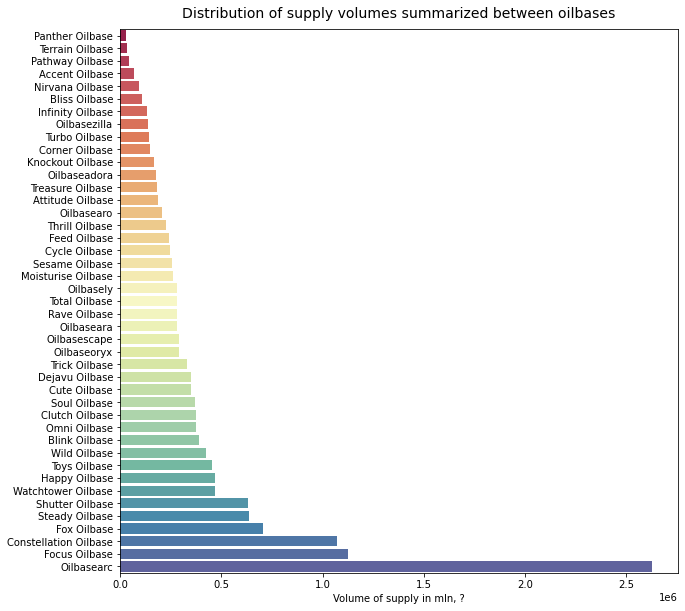

In [225]:
# Save the sorted dataframe
oil_sorted = pd.DataFrame(bandwidth.groupby('origin')['volume'].sum().round(0).reset_index()).sort_values(by='volume')

oil_sorted.rename(columns={'volume': 'supply'}, inplace=True)

colors = sns.color_palette("Spectral", len(oil_sorted))

data_oil = oil_sorted['supply'].values 
labels = oil_sorted['origin'].values

plt.figure(figsize=(10,10))
plt.title("Distribution of supply volumes summarized between oilbases", loc='center', y=1.01, fontsize=14)
plt.xlabel("Volume of supply in mln, ?")

sns.barplot(x=data_oil, y=labels, orient='h', palette=colors)

plt.show()

In [226]:
# Create columns with cumulative sum of volume and its percentage
oil_sorted['supply_cum_sum'] = np.cumsum(np.array(oil_sorted['supply']))
oil_sorted['supply_percent_cum_sum'] = oil_sorted['supply_cum_sum']/sum(oil_sorted['supply'])

In [227]:
# Create a dict of points-demand
df_test = pd.DataFrame(select_time_period(real).groupby(['point'])['volume'].sum()).reset_index()
df_test['point'] = df_test['point'].map(lambda x: int(x.strip('АЗС ')))

point_demand_dict = dict(zip(df_test.point.values,df_test.volume.values))

In [228]:
# Create a dict of origins and list of related points
df_test_2 = select_time_period(data)
df_test_2['point'] = df_test_2['point'].map(lambda x: int(x.strip('АЗС ')))

origins_dict_list = create_origins_dict_list(df_test_2)

<ipython-input-228-5a702b343631>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_2['point'] = df_test_2['point'].map(lambda x: int(x.strip('АЗС ')))


In [229]:
origins_dict = create_origins_dict(select_time_period(data))
oil_sorted['related_points'] = oil_sorted['origin'].map(origins_dict)
oil_sorted = oil_sorted.sort_values('related_points')
oil_sorted['related_points_cum_sum'] = np.cumsum(np.array(oil_sorted['related_points']))
oil_sorted['related_points_percent_cum_sum'] = oil_sorted['related_points_cum_sum']/sum(oil_sorted['related_points'])

In [230]:
# Create a dict of origin and related demand
origin_sum_demand = {}
for k,v_list in origins_dict_list.items():
    summa = []
    for v in v_list:
        summa.append(point_demand_dict [v])
    origin_sum_demand[k] = sum(np.array(summa))

In [231]:
oil_sorted['related_demand'] = oil_sorted['origin'].map(origin_sum_demand)
oil_sorted = oil_sorted.sort_values(by='related_demand')
oil_sorted['related_demand_cum_sum'] = np.cumsum(np.array(oil_sorted['related_demand']))
oil_sorted['demand_percent_cum_sum'] = oil_sorted['related_demand_cum_sum']/sum(oil_sorted['related_demand'])

In [232]:
# Decode oil bases indexes
number = 0
oilbases_dict = dict()

for i in bandwidth['origin'].unique():
    oilbases_dict[i] = number
    number+=1

In [233]:
oil_sorted = oil_sorted[['origin', 'supply', 'related_points', 'related_demand']].round(2)
oil_sorted['supply/demand'] = oil_sorted['supply']/ oil_sorted['related_demand'].round(2)
oil_sorted['origin_name'] = oil_sorted['origin']
oil_sorted['origin'] = oil_sorted['origin_name'].map(oilbases_dict)
oil_sorted.sort_values(by='supply/demand', ascending=False)

,origin,supply,related_points,related_demand,supply/demand,origin_name
11,10,1128261.0,137,72646.23,15.530895,Focus Oilbase
29,28,282072.0,26,18454.00,15.285141,Rave Oilbase
41,40,470093.0,51,31714.14,14.822820,Watchtower Oilbase
2,2,388754.0,32,27527.05,14.122618,Blink Oilbase
30,29,258552.0,26,18454.00,14.010621,Sesame Oilbase
32,31,368592.0,32,27527.05,13.390174,Soul Oilbase
20,19,2625011.0,445,286575.84,9.159917,Oilbasearc
5,5,1072747.0,287,144588.26,7.419323,Constellation Oilbase
13,12,470093.0,120,79915.39,5.882384,Happy Oilbase
12,11,705234.0,325,177346.22,3.976594,Fox Oilbase


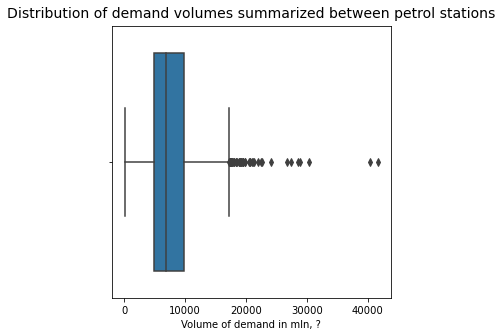

In [234]:
# Save the sorted dataframe
petrol_sorted = pd.DataFrame(real.groupby('point')['volume'].sum().round(0).reset_index())\
                                                                           .sort_values(by='volume')

data_oil = petrol_sorted['volume'].values 
#labels = petrol_sorted['point'].values

plt.figure(figsize=(5,5))
plt.title("Distribution of demand volumes summarized between petrol stations", loc='center', y=1.01, fontsize=14)
plt.xlabel("Volume of demand in mln, ?")

sns.boxplot(x=data_oil, orient='h')

plt.show()

## For selected regions

In [276]:
data_subset = select_region(data)

In [277]:
real_subset = real[(real['date'] == constants['MONTH']) & (real['point'].isin(data_subset['point'].unique()))]

bandwidth_subset = bandwidth[(bandwidth['date'] == constants['MONTH'])&(bandwidth['origin']\
                                                                        .isin(data_subset['origin'].unique()))]

In [278]:
df_origin_point_region = data_subset[~(data_subset.duplicated(subset=['origin', 'point', 'region', 'date']))
                                     & (data_subset['date'] == constants['MONTH'])][['origin', 'point', 'region']]


In [279]:
dict_origin_point_region = {}

for r in df_origin_point_region['region'].unique():
    
    # Create a list of points and origins
    point_list = list(df_origin_point_region[df_origin_point_region['region'] == r]['point'].unique())
    origin_list = list(df_origin_point_region[df_origin_point_region['region'] == r]['origin'].unique())
    
    real_sub = real_subset.groupby(['product'])['volume'].sum().round(2).to_dict()
            
    bandwidth_sub = bandwidth_subset.groupby(['product'])['volume'].sum().round(2).to_dict()
    
    dict_origin_point_region[r] = {'point': point_list, 
                                   'origin': origin_list,
                                   'demand': real_sub,
                                   'supply': bandwidth_sub}

In [280]:
dict_total = {}


for r in df_origin_point_region['region'].unique():
    s_e_d = 0
    d_e_s = 0
    for k, v in dict_origin_point_region[r]['demand'].items():
        # Check if supply exceeds demand
        if dict_origin_point_region[r]['supply'].get(k) is None:
            continue
        else:
            if dict_origin_point_region[r]['supply'][k] >= v:
                s_e_d +=1
            else:
                d_e_s +=1
                
    points_n = len(dict_origin_point_region[r]['point'])
    origins_n = len(dict_origin_point_region[r]['origin'])

    dict_total[r] = {'number of points': points_n,
                     'number of origins': origins_n,
                     'supply exceeds demand': s_e_d, 
                     'demand exceeds supply': d_e_s, 
                     'percent_supply_exceeds_demand': s_e_d/(s_e_d + d_e_s)}
    

In [281]:
# Dataframe with comparison of demand and supply
pd.DataFrame(dict_total).T

,number of points,number of origins,supply exceeds demand,demand exceeds supply,percent_supply_exceeds_demand
Регион 1,137.0,1.0,4.0,0.0,1.0
Регион 2,445.0,3.0,4.0,0.0,1.0
Регион 4,146.0,5.0,4.0,0.0,1.0


In [282]:
r_s = real_subset.groupby('product').sum().reset_index()[['product', 'volume']]

b_s = bandwidth_subset.groupby('product').sum().reset_index()[['product', 'volume']]
    
rb_s = r_s.merge(b_s, on='product', how = 'outer', suffixes = ('_demand', '_supply')).fillna(0).round(2)
rb_s['supply_exceeds_demand'] = rb_s['volume_supply'] >= rb_s['volume_demand']

In [283]:
rb_s

,product,volume_demand,volume_supply,supply_exceeds_demand
0,АИ-100,4774.05,14559.32,True
1,АИ-92,84507.26,102094.31,True
2,АИ-95,120979.70,140836.60,True
3,ДТ,139873.86,195191.17,True


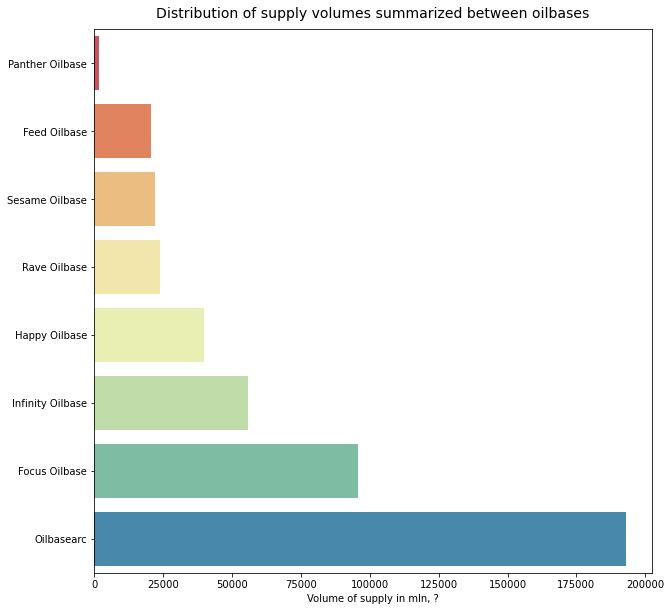

In [284]:
# Save the sorted dataframe
oil_sorted = pd.DataFrame(bandwidth_subset.groupby('origin')['volume'].sum().round(0).reset_index())\
                                                                                     .sort_values(by='volume')

oil_sorted.rename(columns={'volume': 'supply'}, inplace=True)

colors = sns.color_palette("Spectral", len(oil_sorted))

data_oil = oil_sorted['supply'].values 
labels = oil_sorted['origin'].values

plt.figure(figsize=(10,10))
plt.title("Distribution of supply volumes summarized between oilbases", loc='center', y=1.01, fontsize=14)
plt.xlabel("Volume of supply in mln, ?")

sns.barplot(x=data_oil, y=labels, orient='h', palette=colors)

plt.show()

In [285]:
# Create columns with cumulative sum of volume and its percentage
oil_sorted['supply_cum_sum'] = np.cumsum(np.array(oil_sorted['supply']))
oil_sorted['supply_percent_cum_sum'] = oil_sorted['supply_cum_sum']/sum(oil_sorted['supply'])

In [286]:
# Create a dict of points-demand
df_test = pd.DataFrame(select_time_period(real_subset).groupby(['point'])['volume'].sum()).reset_index()
df_test['point'] = df_test['point'].map(lambda x: int(x.strip('АЗС ')))

point_demand_dict = dict(zip(df_test.point.values,df_test.volume.values))

In [287]:
# Create a dict of origins and list of related points
df_test_2 = select_time_period(data_subset)
df_test_2['point'] = df_test_2['point'].map(lambda x: int(x.strip('АЗС ')))

origins_dict_list = create_origins_dict_list(df_test_2)

<ipython-input-287-f0dfca574cbc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_2['point'] = df_test_2['point'].map(lambda x: int(x.strip('АЗС ')))


In [288]:
origins_dict = create_origins_dict(select_time_period(data_subset))
oil_sorted['related_points'] = oil_sorted['origin'].map(origins_dict)
oil_sorted = oil_sorted.sort_values('related_points')
oil_sorted['related_points_cum_sum'] = np.cumsum(np.array(oil_sorted['related_points']))
oil_sorted['related_points_percent_cum_sum'] = oil_sorted['related_points_cum_sum']/sum(oil_sorted['related_points'])

In [289]:
# Create a dict of origin and related demand
origin_sum_demand = {}
for k,v_list in origins_dict_list.items():
    summa = []
    for v in v_list:
        summa.append(point_demand_dict[v])
    origin_sum_demand[k] = sum(np.array(summa))

In [290]:
oil_sorted['related_demand'] = oil_sorted['origin'].map(origin_sum_demand)
oil_sorted = oil_sorted.sort_values(by='related_demand')
oil_sorted['related_demand_cum_sum'] = np.cumsum(np.array(oil_sorted['related_demand']))
oil_sorted['demand_percent_cum_sum'] = oil_sorted['related_demand_cum_sum']/sum(oil_sorted['related_demand'])

In [291]:
# Decode oil bases indexes
number = 0
oilbases_dict = dict()

for i in bandwidth_subset['origin'].unique():
    oilbases_dict[i] = number
    number+=1

In [292]:
oil_sorted = oil_sorted[['origin', 'supply', 'related_points', 'related_demand']].round(2)
oil_sorted['supply/demand'] = oil_sorted['supply']/ oil_sorted['related_demand'].round(2)
oil_sorted['origin_name'] = oil_sorted['origin']
oil_sorted['origin'] = oil_sorted['origin_name'].map(oilbases_dict)
oil_sorted.sort_values(by='supply/demand', ascending=False)

,origin,supply,related_points,related_demand,supply/demand,origin_name
1,1,95825.0,137,72646.23,1.319064,Focus Oilbase
6,6,23957.0,26,18454.00,1.298201,Rave Oilbase
7,7,21959.0,26,18454.00,1.189932,Sesame Oilbase
4,4,192811.0,445,286575.84,0.672810,Oilbasearc
2,2,39926.0,120,79915.39,0.499603,Happy Oilbase
0,0,20677.0,120,79915.39,0.258736,Feed Oilbase
3,3,55897.0,445,286575.84,0.195051,Infinity Oilbase
5,5,1630.0,26,18454.00,0.088328,Panther Oilbase


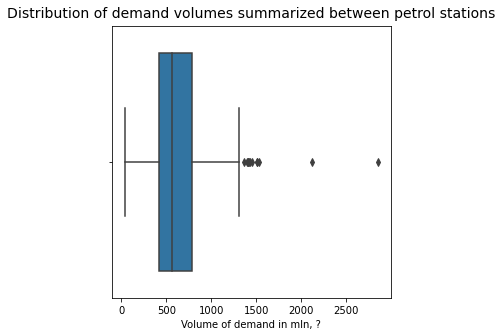

In [293]:
# Save the sorted dataframe
petrol_sorted = pd.DataFrame(real_subset.groupby('point')['volume'].sum().round(0).reset_index())\
                                                                                  .sort_values(by='volume')

data_oil = petrol_sorted['volume'].values 
#labels = petrol_sorted['point'].values

plt.figure(figsize=(5,5))
plt.title("Distribution of demand volumes summarized between petrol stations", loc='center', y=1.01, fontsize=14)
plt.xlabel("Volume of demand in mln, ?")

sns.boxplot(x=data_oil, orient='h')

plt.show()